# Time Series (River Discharge) Forecasting using different types of Neural Networks

## _Initialization_

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import statsmodels
import statsmodels.api as sm

import tensorflow as tf
from tensorflow import keras

%matplotlib inline

In [2]:
# tracking version for future
print('python version : ' + sys.version)
print('numpy version : ' + np.__version__)
print('pandas version : ' + pd.__version__)
print('matplotlib version : ' + matplotlib.__version__)
print('seaborn version : ' + seaborn.__version__)
print('statsmodels version : ' + statsmodels.__version__)
print('tensorflow version : ' + tf.__version__)
print('keras version : ' + keras.__version__)

python version : 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
numpy version : 1.16.4
pandas version : 0.24.2
matplotlib version : 3.1.1
seaborn version : 0.9.1.dev0
statsmodels version : 0.10.0
tensorflow version : 1.14.0
keras version : 2.2.4-tf


In [3]:
plt.rcParams['figure.figsize'] = [16,6]
plt.rcParams["legend.framealpha"] = 0.3

plt.rcParams['font.family'] = 'serif'
plt.rcParams["font.size"] = "14"

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["mathtext.rm"] = 'serif'
plt.rcParams["mathtext.it"] = 'serif:italic'
plt.rcParams["mathtext.bf"] = 'serif:bold'

In [4]:
# eps don't support Cambria font. So, differnt font setup for jpg and eps
def save_jpg(name):
    plt.rcParams['font.serif'] = 'Cambria'
    plt.savefig(name, format='jpg',dpi = 600)
    
def save_eps(name):
    plt.rcParams['font.serif'] = 'Times New Roman'
    plt.savefig(name, format='eps',dpi = 600)

## _Pre-processing and Exploratory Data Analysis_

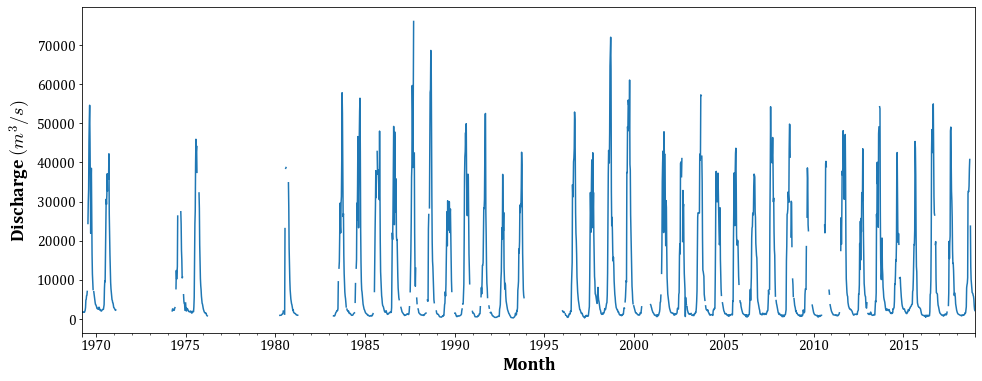

In [5]:
# load data
data = pd.read_csv("SW90_For_Book.csv")
data.Date = pd.to_datetime(data.Date,format='%d/%m/%Y')
data.index = data.Date

# convert into weekly data & check data condition
weeklyData = data.resample('w').mean()
weeklyData.drop(columns=['Water_Level(m)','Max_Velocity'],inplace=True)
weeklyData.Discharge[weeklyData.Discharge == 0] = np.nan
weeklyData.plot(legend='');

plt.xlabel('Month', fontdict={'weight': 'bold', 'size': 18})
plt.ylabel(r'Discharge $(m^3/s)$', fontdict={'weight': 'bold', 'size': 18})

save_eps('Result/timeSeries.eps')
save_jpg('Result/timeSeries.jpg')

**_Above figure shows that The missing data is comparatively low after 2001. So, we use 1996 to 2018 for our analysis._**

In [6]:
# Select required data and check missing data percentage 
CleanData = weeklyData['2001-01-01':'2018-12-31'].copy()
miss = CleanData['Discharge'].isnull().sum() / CleanData.shape[0] * 100
print('Percentage  of Missing : ' + str(miss) + ' %')

Percentage  of Missing : 5.218317358892439 %


**_percentage of Missing is below 6%, which acceptable. Before use this data into model, we fill-up missing values using linear interpolation._**

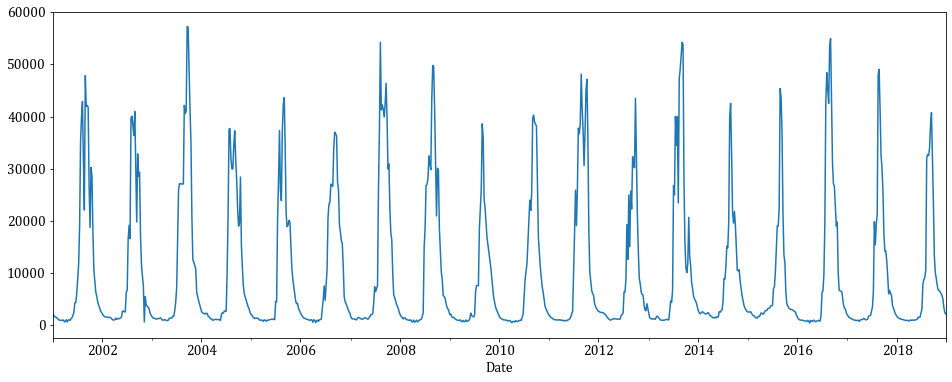

In [7]:
# fillup missing values using linear interpolation
CleanData.interpolate(method='linear', limit_direction='forward', axis=0, inplace =True)
CleanData.plot(legend='');

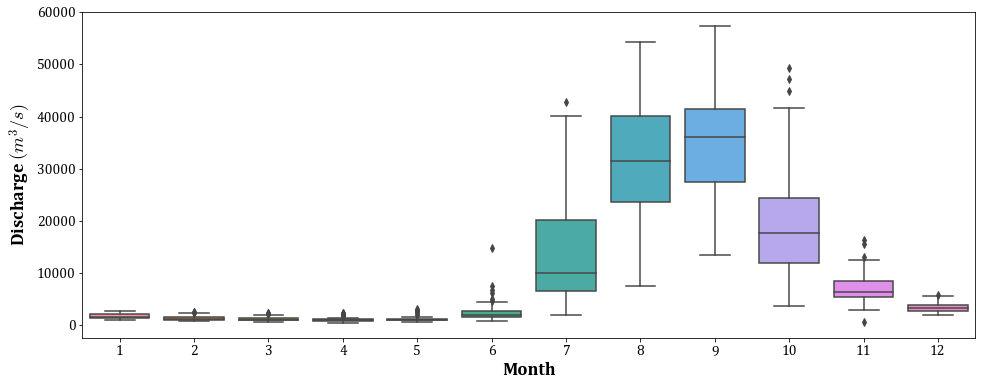

In [8]:
# Visualize Monthly condition of data using Boxplot
seaborn.boxplot(CleanData.index.month, CleanData.Discharge)

plt.xlabel('Month', fontdict={'weight': 'bold', 'size': 18})
plt.ylabel(r'Discharge $(m^3/s)$', fontdict={'weight': 'bold', 'size': 18})

save_eps('Result/BoxPlot.eps')
save_jpg('Result/BoxPlot.jpg')

W1010 17:15:25.761104  9904 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


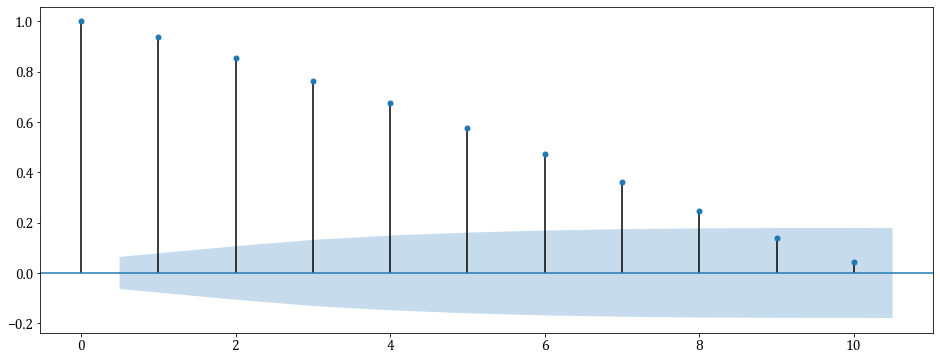

In [9]:
# Check Autocorrelation (ACF) plot to understand and determine the influence of past on recent data.
sm.graphics.tsa.plot_acf(CleanData,lags=10,title='');

save_eps('Result/acf.eps')
save_jpg('Result/acf.jpg')

**_The above figure shows that there is a significant correlation until 9th lags. So, we use 8-lags data as input in our model_**

In [10]:
# Prepared data for model
lags = 8
processData = list()
colName = list()

for i in range(lags, -1, -1):
    processData.append(CleanData.shift(i))
    colName.append('t - ' + str(i))

processData = pd.concat(processData, axis=1)
processData.columns = colName

# Remove first 8 raw, which contain NaN values
processData = processData.iloc[8:,:]

# Split into Train, test and validation dataset.
X = processData.drop('t - 0', axis=1).to_numpy()
y = processData['t - 0'].to_numpy()

testNo = 52 * 2     # Two year data for testset
validNo = 52 * 2    # Two year data for validationset
trainNo = processData.shape[0] - testNo - validNo    # Rest of the data for Training-set

X_train = X[:trainNo]
y_train = y[:trainNo]
X_test = X[trainNo : trainNo + testNo]
y_test = y[trainNo : trainNo + testNo]
X_val = X[trainNo + testNo : trainNo + testNo + validNo]
y_val = y[trainNo + testNo : trainNo + testNo + validNo]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape(( y_train.shape[0], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test = y_test.reshape(( y_test.shape[0], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
y_val = y_val.reshape(( y_val.shape[0], 1))

## _Model Development and Selection_

In [13]:
ModelPerformance = pd.DataFrame()

# Different number of neurons for hidden layer
NeuronNo = [5, 10, 15, 20, 25, 30]

# MLP
ModelName = 'MLP'
for i in NeuronNo:
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(i),
        keras.layers.Dense(1)
    ])

    model.compile(loss="mse", optimizer="adam")
    history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_data=(X_test,y_test))
    
    ModelPerformance = ModelPerformance.append({'Model':ModelName, 'Neuron': i, 'Train_RMSE': np.sqrt(history.history['loss'][-1]), 'Test_RMSE':np.sqrt(history.history['val_loss'][-1])}, ignore_index=True)
    print('Model : ' + ModelName + ', Neuron : ' + str(i))
    
# RNN
ModelName = 'RNN'
for i in NeuronNo:
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(i, activation='relu',return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(1, activation='relu')
    ])

    model.compile(loss="mse", optimizer="adam")
    history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_data=(X_test,y_test))
    
    ModelPerformance = ModelPerformance.append({'Model':ModelName, 'Neuron': i, 'Train_RMSE': np.sqrt(history.history['loss'][-1]), 'Test_RMSE':np.sqrt(history.history['val_loss'][-1])}, ignore_index=True)
    print('Model : ' + ModelName + ', Neuron : ' + str(i))
    
# LSTM
ModelName = 'LSTM'
for i in NeuronNo:
    model = keras.models.Sequential([
        keras.layers.LSTM(i, activation='relu'),
        keras.layers.Dense(1)
    ])

    model.compile(loss="mse", optimizer="adam")
    history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_data=(X_test,y_test))
    
    ModelPerformance = ModelPerformance.append({'Model':ModelName, 'Neuron': i, 'Train_RMSE': np.sqrt(history.history['loss'][-1]), 'Test_RMSE':np.sqrt(history.history['val_loss'][-1])}, ignore_index=True)
    print('Model : ' + ModelName + ', Neuron : ' + str(i))

# GRU
ModelName = 'GRU'
for i in NeuronNo:
    model = keras.models.Sequential([
        keras.layers.GRU(i, activation='relu'),
        keras.layers.Dense(1)
    ])

    model.compile(loss="mse", optimizer="adam")
    history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_data=(X_test,y_test))
    
    ModelPerformance = ModelPerformance.append({'Model':ModelName, 'Neuron': i, 'Train_RMSE': np.sqrt(history.history['loss'][-1]), 'Test_RMSE':np.sqrt(history.history['val_loss'][-1])}, ignore_index=True)
    print('Model : ' + ModelName + ', Neuron : ' + str(i))

# CNN
ModelName = 'CNN'
ConvLayerNo = [1,2]

for layers in ConvLayerNo:
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=[X_train.shape[1], 1]))

    for i in range(layers):
        model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu')),
        model.add(keras.layers.MaxPooling1D(pool_size=2))

    model.add(keras.layers.Flatten()),
    model.add(keras.layers.Dense(1))

    model.compile(loss="mse", optimizer="adam")
    history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_data=(X_test,y_test))

    ModelPerformance = ModelPerformance.append({'Model':ModelName, 'Conv_Layer': layers, 'Train_RMSE': np.sqrt(history.history['loss'][-1]), 'Test_RMSE':np.sqrt(history.history['val_loss'][-1])}, ignore_index=True)
    print('Model : ' + ModelName + ', Conv_Layer : ' + str(i + 1))
    
# WaveNet
ModelName = 'WaveNet'
DilationRate = [2, 4, 8, 16, 32]

for layers in range(len(DilationRate)):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=[X_train.shape[1], 1]))

    for i in range(layers+1):
        model.add(keras.layers.Conv1D(filters=10, kernel_size=2, activation='relu', padding="causal",dilation_rate=DilationRate[i])),

    model.add(keras.layers.Flatten()),
    model.add(keras.layers.Dense(1))

    model.compile(loss="mse", optimizer="adam")
    history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_data=(X_test,y_test))

    ModelPerformance = ModelPerformance.append({'Model': ModelName, 'Conv_Layer': i + 1, 'Dilation_Rate': DilationRate[i], 'Train_RMSE': np.sqrt(history.history['loss'][-1]), 'Test_RMSE':np.sqrt(history.history['val_loss'][-1])}, ignore_index=True)
    print('Model : ' + ModelName + ', Dilation_Rate : ' + str(DilationRate[i]))

Model : MLP, Neuron : 5
Model : MLP, Neuron : 10
Model : MLP, Neuron : 15
Model : MLP, Neuron : 20
Model : MLP, Neuron : 25
Model : MLP, Neuron : 30
Model : RNN, Neuron : 5
Model : RNN, Neuron : 10
Model : RNN, Neuron : 15
Model : RNN, Neuron : 20
Model : RNN, Neuron : 25
Model : RNN, Neuron : 30
Model : LSTM, Neuron : 5
Model : LSTM, Neuron : 10
Model : LSTM, Neuron : 15
Model : LSTM, Neuron : 20
Model : LSTM, Neuron : 25
Model : LSTM, Neuron : 30
Model : GRU, Neuron : 5
Model : GRU, Neuron : 10
Model : GRU, Neuron : 15
Model : GRU, Neuron : 20
Model : GRU, Neuron : 25
Model : GRU, Neuron : 30
Model : CNN, Conv_Layer : 1
Model : CNN, Conv_Layer : 2
Model : WaveNet, Dilation_Rate : 2
Model : WaveNet, Dilation_Rate : 4
Model : WaveNet, Dilation_Rate : 8
Model : WaveNet, Dilation_Rate : 16
Model : WaveNet, Dilation_Rate : 32


In [14]:
# Check models performance for first hidden layer
ModelPerformance.to_csv('Result/Model_Performance_1.csv')
ModelPerformance

,Model,Neuron,Test_RMSE,Train_RMSE,Conv_Layer,Dilation_Rate
0,MLP,5.0,6042.882035,5462.229097,NaN,NaN
1,MLP,10.0,4938.452732,4760.309234,NaN,NaN
2,MLP,15.0,4622.973968,4516.038983,NaN,NaN
3,MLP,20.0,4420.159665,4538.943915,NaN,NaN
4,MLP,25.0,4589.513176,4480.835645,NaN,NaN
5,MLP,30.0,4693.205926,4534.024206,NaN,NaN
6,RNN,5.0,16522.929597,17066.688660,NaN,NaN
7,RNN,10.0,16522.930025,17066.688633,NaN,NaN
8,RNN,15.0,16522.929969,17066.688713,NaN,NaN
9,RNN,20.0,16522.929895,17066.688643,NaN,NaN


**_Best Models are_ -
MLP :** 20,
**RNN :** 25,
**LSTM :** 10,
**GRU :** 20,
**CNN :** None of them is good,
**WaveNet :** 3

In [15]:
# Create Models to find best neuron no in second hidden layer.
ModelPerformance2 = pd.DataFrame()

# Different number of neurons for second hidden layer
NeuronNo = [5, 10, 15, 20, 25, 30]

# Best number of neurons for first hidden layer,find from previous model performance
BestModel = {'MLP' : 20,
            'RNN' : 25,
            'LSTM' : 10,
            'GRU' : 20,
            'CNN' : 0,
            'WaveNet' : 3}

# MLP
ModelName = 'MLP'
for i in NeuronNo:
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(BestModel['MLP']),
        keras.layers.Dense(i),
        keras.layers.Dense(1)
    ])

    model.compile(loss="mse", optimizer="adam")
    history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_data=(X_test,y_test))
    
    ModelPerformance2 = ModelPerformance2.append({'Model':ModelName, 'Neuron': i, 'Train_RMSE': np.sqrt(history.history['loss'][-1]), 'Test_RMSE':np.sqrt(history.history['val_loss'][-1])}, ignore_index=True)
    print('Model : ' + ModelName + ', Neuron : ' + str(i))
    
# RNN
ModelName = 'RNN'
for i in NeuronNo:
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(BestModel['RNN'], activation='relu',return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(i, activation='relu',return_sequences=True),
        keras.layers.SimpleRNN(1, activation='relu')
    ])

    model.compile(loss="mse", optimizer="adam")
    history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_data=(X_test,y_test))
    
    ModelPerformance2 = ModelPerformance2.append({'Model':ModelName, 'Neuron': i, 'Train_RMSE': np.sqrt(history.history['loss'][-1]), 'Test_RMSE':np.sqrt(history.history['val_loss'][-1])}, ignore_index=True)
    print('Model : ' + ModelName + ', Neuron : ' + str(i))
    
# LSTM
ModelName = 'LSTM'
for i in NeuronNo:
    model = keras.models.Sequential([
        keras.layers.LSTM(BestModel['LSTM'], return_sequences=True, activation='relu'),
        keras.layers.LSTM(i, activation='relu'),
        keras.layers.Dense(1)
    ])

    model.compile(loss="mse", optimizer="adam")
    history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_data=(X_test,y_test))
    
    ModelPerformance2 = ModelPerformance2.append({'Model':ModelName, 'Neuron': i, 'Train_RMSE': np.sqrt(history.history['loss'][-1]), 'Test_RMSE':np.sqrt(history.history['val_loss'][-1])}, ignore_index=True)
    print('Model : ' + ModelName + ', Neuron : ' + str(i))

# GRU
ModelName = 'GRU'
for i in NeuronNo:
    model = keras.models.Sequential([
        keras.layers.GRU(BestModel['GRU'], return_sequences=True, activation='relu'),
        keras.layers.GRU(i, activation='relu'),
        keras.layers.Dense(1)
    ])

    model.compile(loss="mse", optimizer="adam")
    history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_data=(X_test,y_test))
    
    ModelPerformance2 = ModelPerformance2.append({'Model':ModelName, 'Neuron': i, 'Train_RMSE': np.sqrt(history.history['loss'][-1]), 'Test_RMSE':np.sqrt(history.history['val_loss'][-1])}, ignore_index=True)
    print('Model : ' + ModelName + ', Neuron : ' + str(i))
    
# WaveNet
ModelName = 'WaveNet'
for i in NeuronNo:
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=[X_train.shape[1], 1]))

    model.add(keras.layers.Conv1D(filters=10, kernel_size=2, activation='relu', padding="causal",dilation_rate=2)),
    model.add(keras.layers.Conv1D(filters=10, kernel_size=2, activation='relu', padding="causal",dilation_rate=4)),
    model.add(keras.layers.Conv1D(filters=10, kernel_size=2, activation='relu', padding="causal",dilation_rate=8)),

    model.add(keras.layers.Flatten()),
    model.add(keras.layers.Dense(i, activation='relu'))
    model.add(keras.layers.Dense(1))

    model.compile(loss="mse", optimizer="adam")
    history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_data=(X_test,y_test))

    ModelPerformance2 = ModelPerformance2.append({'Model': ModelName, 'Neuron': i, 'Train_RMSE': np.sqrt(history.history['loss'][-1]), 'Test_RMSE':np.sqrt(history.history['val_loss'][-1])}, ignore_index=True)
    print('Model : ' + ModelName + ', Neuron : ' + str(i))

Model : MLP, Neuron : 5
Model : MLP, Neuron : 10
Model : MLP, Neuron : 15
Model : MLP, Neuron : 20
Model : MLP, Neuron : 25
Model : MLP, Neuron : 30
Model : RNN, Neuron : 5
Model : RNN, Neuron : 10
Model : RNN, Neuron : 15
Model : RNN, Neuron : 20
Model : RNN, Neuron : 25
Model : RNN, Neuron : 30
Model : LSTM, Neuron : 5
Model : LSTM, Neuron : 10
Model : LSTM, Neuron : 15
Model : LSTM, Neuron : 20
Model : LSTM, Neuron : 25
Model : LSTM, Neuron : 30
Model : GRU, Neuron : 5
Model : GRU, Neuron : 10
Model : GRU, Neuron : 15
Model : GRU, Neuron : 20
Model : GRU, Neuron : 25
Model : GRU, Neuron : 30
Model : WaveNet, Neuron : 5
Model : WaveNet, Neuron : 10
Model : WaveNet, Neuron : 15
Model : WaveNet, Neuron : 20
Model : WaveNet, Neuron : 25
Model : WaveNet, Neuron : 30


In [16]:
# Check models performance
ModelPerformance2.to_csv('Result/Model_Performance_2.csv')
ModelPerformance2

,Model,Neuron,Test_RMSE,Train_RMSE
0,MLP,5.0,4864.140125,4579.359360
1,MLP,10.0,4569.320199,4526.895370
2,MLP,15.0,4492.957909,4509.160988
3,MLP,20.0,4567.138328,4740.720914
4,MLP,25.0,4578.662418,4496.439925
5,MLP,30.0,4567.969365,4556.888751
6,RNN,5.0,5711.660718,4601.587735
7,RNN,10.0,5336.098330,4561.039620
8,RNN,15.0,16522.930398,17066.688613
9,RNN,20.0,5271.096631,4479.707371


**_Here best model is MPL with 15 Neuron in second hidden layer_**

## _Finalize Model and Evaluation_

In [17]:
# finalize the model by reviewing the previous results
model = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(20),
    keras.layers.Dense(15),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test,y_test))

# Save final model to reuse it later
model.save('Result/Final_8-20-15-1_Model.h5')

# to load saved model
# model = keras.models.load_model('Result/Final_8-15-15-1_Model.h5')

valRes = pd.DataFrame({'Original': y_val[:,0],'Predict' : model.predict(X_val)[:,0]}, columns = ['Original','Predict'])

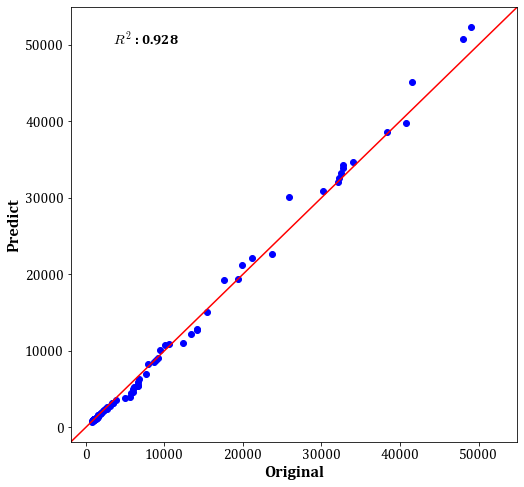

In [18]:
# Evaluate Final model accuracy using validation dataset
fig, ax = plt.subplots(figsize=(8,8))
sm.qqplot_2samples(valRes.iloc[:,1],valRes.iloc[:,0],line='45',ax=ax);

plt.text(3000, 50000, r'$\ R^2$ : ' + str(round(valRes.corr().iloc[0,1], 3)), fontdict={'weight': 'bold'});
plt.xlabel('Original', fontdict={'weight': 'bold', 'size': 16})
plt.ylabel('Predict', fontdict={'weight': 'bold', 'size': 16})

save_eps('Result/QQplot.eps')
save_jpg('Result/QQplot.jpg')

W1010 17:58:54.613228  9904 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1010 17:58:54.613228  9904 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


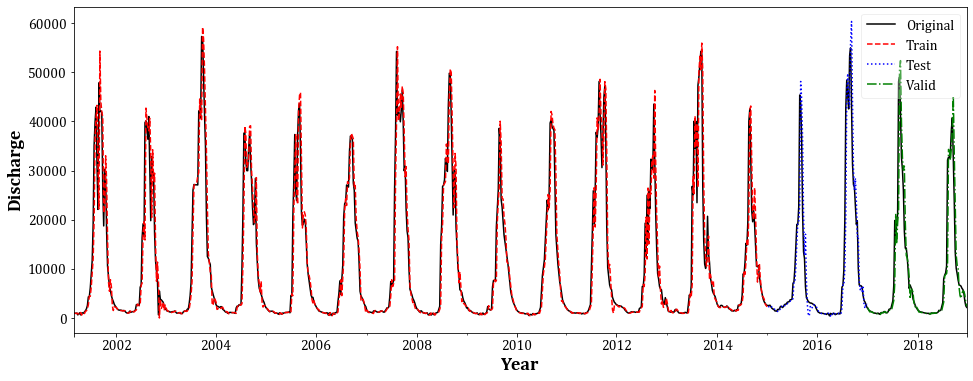

In [19]:
# Visualize Final model performance and save results
FinalRes = pd.DataFrame([],columns=['Original','Train','Test','Valid'])

FinalRes['Original'] = processData['t - 0']
FinalRes.iloc[:trainNo, FinalRes.columns == 'Train'] = model.predict(X_train)[:,0]
FinalRes.iloc[trainNo : trainNo + testNo, FinalRes.columns == 'Test'] = model.predict(X_test)[:,0]
FinalRes.iloc[trainNo + testNo : trainNo + testNo + validNo, FinalRes.columns == 'Valid'] = model.predict(X_val)[:,0]

resfig = FinalRes.plot(style=['-','--',':','-.'],color=['k','r','b','g'])

plt.xlabel('Year', fontdict={'weight': 'bold', 'size': 18}) #, fontdict=font);
plt.ylabel('Discharge', fontdict={'weight': 'bold', 'size': 18}) #, fontdict=font);
plt.legend(loc='upper right')

save_eps('Result/Compare.eps')
save_jpg('Result/Compare.jpg')
FinalRes.to_csv('Result/FinalResult.csv')